# Импорт библиотек и функции

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
def plot_training_curves(history):

  tr_mae = history.history['mae'] # mae на тренировочном наборе
  tr_loss = history.history['loss'] # ошибка на тренировочном наборе
  val_mae = history.history['val_mae'] # mae на валидационном наборе
  val_loss = history.history['val_loss']  # ошибка на валидационном наборе
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmin(val_mae)
  acc_highest = val_mae[index_acc]
  epochs = [i+1 for i in range(len(tr_mae))] # количество эпох обучения
  loss_label = f'best epoch = {str(index_loss + 1)}'
  acc_label = f'best epoch = {str(index_acc + 1)}'

  # Plot training history
  plt.figure(figsize= (12, 5))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(epochs, tr_loss, 'r', label='Ошибка обучения')
  plt.plot(epochs, val_loss, 'g', label='Ошибка валидации')
  plt.scatter(index_loss + 1, val_lowest, s=150, c= 'blue', label=loss_label)
  plt.title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение ошибки', fontsize=12)
  plt.legend(fontsize=12)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, tr_mae, 'r', label='MAE обучения')
  plt.plot(epochs, val_mae, 'g', label='MAE валидации')
  plt.scatter(index_acc + 1 , acc_highest, s=150, c= 'blue', label=acc_label)
  plt.title('MAE при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение точности', fontsize=12)
  plt.legend(fontsize=12)

  plt.tight_layout
  plt.show()

  return

# Функция для подсчета метрик модели регрессии
def generate_preformance_scores(y_true, y_pred):

  mse = mean_squared_error(y_test, y_pred) # расчет mean squared error
  mae = mean_absolute_error(y_test, y_pred) # расчет mean absolute error
  r2 = r2_score(y_test, y_pred) # расчет коэффициента детерминации r2

  print(f'mse:\t{mse:.4f}')
  print(f'mae:\t{mae:.4f}')
  print(f'r2:\t{r2:.4f}')

  preformance_scores = {
      'mse_score': mse,
      'mae_score': mae,
      'r2_score': r2
  }

  return preformance_scores

# функция для поиска определения переменной
def what_is(layout_data, col_name):
    # создадим имена переменных и описания переменных в двух отдельных списках
    labels = list(layout_data['Variable Label'])
    places = list(layout_data['Variable Name'])
    pl = places.index(col_name)
    print(col_name, ' is ', labels[pl])

# Чтение данных

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/DS_2019_public.csv', encoding="cp1252", encoding_errors='replace') # читаем данные в перменную df
df.head() # выводим первые 5 строк

<ipython-input-4-e4b11ac2c188>:1: DtypeWarning: Columns (30,56,96,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/DS_2019_public.csv', encoding="cp1252", encoding_errors='replace') # читаем данные в перменную df


,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,16.793,17,181.998,620.979,621,368,38606,...,-2,30110,2,120.893,121,4,0,1,1,1310.220
1,1,1,1,48.901,49,184.459,629.389,629,582,40248,...,2,7933,-2,242.746,243,2,0,1,-2,915.664
2,1,3,7,101.048,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,158.797,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,85.138,85,5,0,1,5,346.468
4,1,4,10,45.132,45,274.530,936.677,937,685,74100,...,3,14204,6,151.319,151,6,0,1,5,920.454


In [ ]:
print(f"Размер набора данных {df.shape}")

Размер набора данных (10875, 121)


In [ ]:
# прочитаем набор данных с объяснением переменных и посмотрим, что обозначают выбранные
layout_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/public_layout.csv', sep=',')

# Исследование данных

In [ ]:
what_is(layout_data, "TOTALDOLCOL")

TOTALDOLCOL  is  Total cost for air conditioning, in whole dollars, 2009


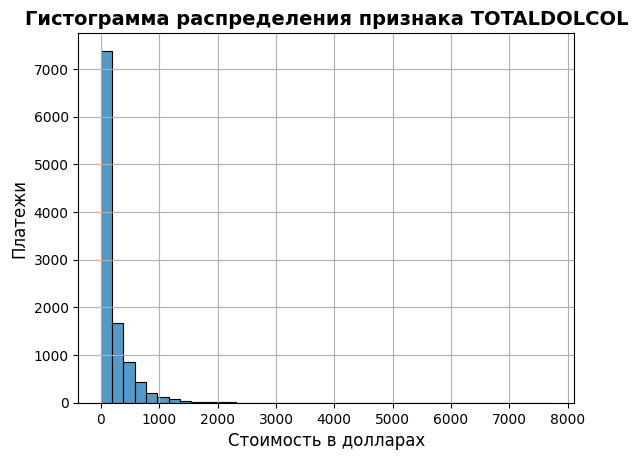

In [ ]:
# гистограмма распределения целевой переменной
sns.histplot(df["TOTALDOLCOL"], bins=40)
plt.title('Гистограмма распределения признака TOTALDOLCOL', fontsize=14, fontweight="bold")
plt.xlabel('Стоимость в долларах', fontsize=12)
plt.ylabel('Платежи', fontsize=12)
plt.grid()

In [ ]:
# посмотрим числовые характеристики целевой переменной
df["TOTALDOLCOL"].describe()

count    10875.000000
mean       202.429333
std        310.691148
min          0.000000
25%         18.000000
50%         90.000000
75%        263.000000
max       7729.000000
Name: TOTALDOLCOL, dtype: float64

Так как переменных в исходном наборе данных 120, отберем только те переменные, корреляция которых с целевой переменной по модулю больше чем 0.6

In [ ]:
corr = df.corr()
th = 0.6

corr_th = corr["TOTALDOLCOL"][abs(corr["TOTALDOLCOL"]) > th]
corr_th

<ipython-input-10-239c6d8c63b4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


TOTALDOLCOL    1.000000
KWHCOL         0.968428
BTUELCOL       0.968428
TOTALBTUCOL    0.968428
DOLLAREL       0.680070
KWH            0.602800
BTUEL          0.602799
Name: TOTALDOLCOL, dtype: float64

In [ ]:
# посмотрим на набор данных с выбранными переменными
df = df.drop(corr["TOTALDOLCOL"][abs(corr["TOTALDOLCOL"]) <= th].keys(), axis=1)
df.head()

,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,DOLLAREL,DOLFOSPH,DOLELSPH,DOLNGWTH,CUFEETNGOTH,KWHOTH,KWH,BTUEL,CUFEETNGWTH,DOLELRFG
0,16.793,17,181.998,620.979,621,475,0.0,0,286.745,167.601,3655.782,5148,17565,293.756,120.893
1,48.901,49,184.459,629.389,629,588,0.0,0,114.618,28.944,1117.878,2218,7568,77.394,242.746
2,101.048,101,1063.022,3627.013,3627,952,0.0,0,0.0,19.848,5393.913,10015,34171,0,158.797
3,0,0,0.000,0.000,0,705,0.0,0,236.762,0,2522.532,2869,9789,135.451,85.138
4,45.132,45,274.530,936.677,937,1050,0.0,0,131.362,41.498,5192.016,6387,21792,138.574,151.319


In [ ]:
# удалим категориальные переменные
df = df.drop(["DOLELCOL", "DOLFOSPH", "DOLELSPH", "DOLNGWTH", "CUFEETNGOTH", "KWHOTH", "CUFEETNGWTH", "CUFEETNGWTH", "DOLELRFG"], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TOTALDOLCOL  10875 non-null  int64  
 1   KWHCOL       10875 non-null  float64
 2   BTUELCOL     10875 non-null  float64
 3   TOTALBTUCOL  10875 non-null  int64  
 4   DOLLAREL     10875 non-null  int64  
 5   KWH          10875 non-null  int64  
 6   BTUEL        10875 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 594.9 KB


In [ ]:
df.shape

(10875, 7)

In [ ]:
# описание выбранных переменных
for col in df.columns.values:
  what_is(layout_data, col)

TOTALDOLCOL  is  Total cost for air conditioning, in whole dollars, 2009
KWHCOL  is  Electricity usage for air-conditioning, central and window/wall (room), in kilowatt-hours, 2009
BTUELCOL  is  Electricity usage for air-conditioning, central and window/wall (room), in thousand BTU, 2009
TOTALBTUCOL  is  Total usage for air conditioning, in thousand BTU, 2009
DOLLAREL  is  Total Electricity cost, in whole dollars, 2009
KWH  is  Total Site Electricity usage, in kilowatt-hours, 2009
BTUEL  is  Total Site Electricity usage, in thousand BTU, 2009


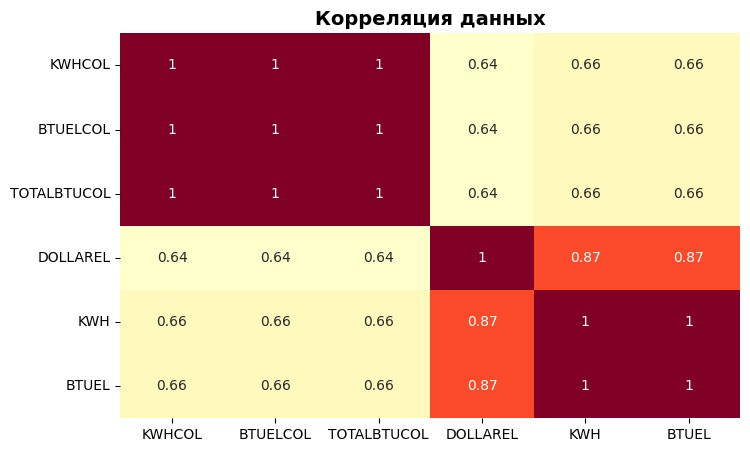

In [ ]:
# корррелция между выбраннными переменными
plt.figure(figsize = (8, 5))
sns.heatmap(df.drop("TOTALDOLCOL", axis=1).corr(), annot=True, cmap ='YlOrRd', cbar=False)
plt.title("Корреляция данных", fontsize=14, fontweight="bold");

# Деление на выборки

In [ ]:
# делим выборку на тренировочную и тестовую
X = df.drop(['TOTALDOLCOL'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['TOTALDOLCOL'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.1, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [ ]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (7830, 6)
Размер тестовой выборки: (2175, 6)
Размер валидационной выборки: (870, 6)


In [ ]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Создание модели

In [ ]:
# создадим переменную, которая выполняет функцию ранней остановки,
# если значение ошибки не уменьшается в течение 10 эпох обучения
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [ ]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"), # 1-й слой с 12 нейронами и ФА relu
    layers.Dense(1) # выходной слой с 1 нейроном и линейной ФА, так как задача регрессии
])

In [ ]:
# компиляция модели
model1.compile(optimizer="adam", # оптимизатор adam
              loss="mse", # функция ошибки mse
              metrics=["mae"]) # метрика mae
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                84        
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [ ]:
history1 = model1.fit(X_train, # признаки
                      y_train, # целевой признак
                      epochs=150, # количество эпох обучения
                      batch_size=32, # размер batch
                      validation_data=(X_val, y_val), # данные для валидации
                      callbacks=callbacks_list # ранняя остановка
                      )

Epoch 1/150
245/245 [==============================] - 1s 3ms/step - loss: 138453.6719 - mae: 201.1483 - val_loss: 125776.4766 - val_mae: 202.9826
Epoch 2/150
245/245 [==============================] - 1s 2ms/step - loss: 134762.8750 - mae: 198.5450 - val_loss: 121327.2422 - val_mae: 199.4147
Epoch 3/150
245/245 [==============================] - 1s 2ms/step - loss: 127886.8281 - mae: 193.9405 - val_loss: 112847.4297 - val_mae: 193.0765
Epoch 4/150
245/245 [==============================] - 1s 2ms/step - loss: 118689.5703 - mae: 187.2477 - val_loss: 104453.7344 - val_mae: 186.2327
Epoch 5/150
245/245 [==============================] - 1s 2ms/step - loss: 108496.9609 - mae: 180.0364 - val_loss: 94402.6406 - val_mae: 177.7964
Epoch 6/150
245/245 [==============================] - 1s 2ms/step - loss: 97364.1406 - mae: 171.3811 - val_loss: 83933.3359 - val_mae: 168.5948
Epoch 7/150
245/245 [==============================] - 1s 2ms/step - loss: 86096.1328 - mae: 161.9451 - val_loss: 73548.9

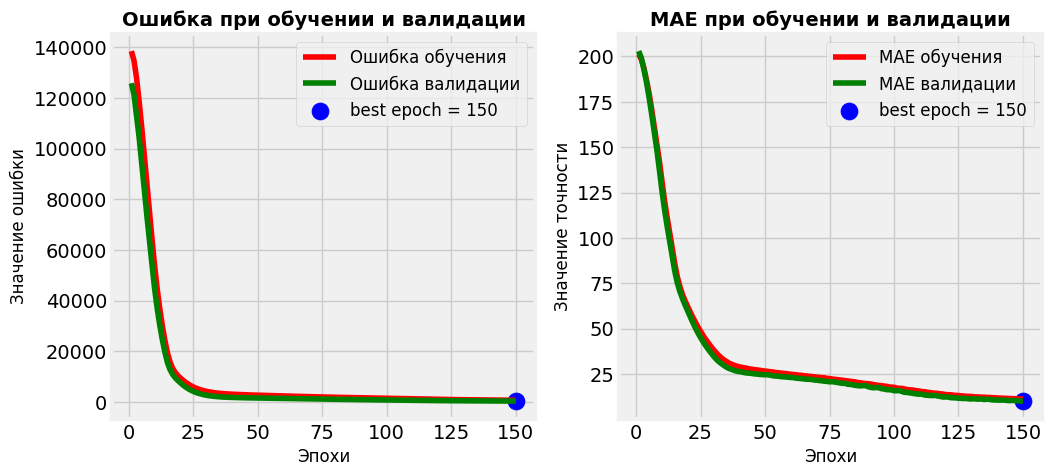

In [ ]:
plot_training_curves(history1)

Видно, что эффекта переобучения на графиках обучения нет

In [ ]:
y_pred = model1.predict(X_test) # обучения модели на тестовом наборе

68/68 [==============================] - 0s 1ms/step


In [ ]:
model1_preformance = generate_preformance_scores(y_test, y_pred)# метрики обучения

mse:	725.8044
mae:	11.2891
r2:	0.9920


Коэффициент детерминации - 99,2%, это означает, что модель имеет отличную предсказательную способность. Исходя из метрики mae при среднем значении целевой переменной 202 долларов, модель ошибается в среднем на 11 долларов.

Время обучения 120 с

Попробуем немного изменить архитектуру модели и провериь как изменится время и метрики обучения

## Модель 2

In [ ]:
model2 = keras.Sequential([
    layers.Dense(8, input_dim=X_train.shape[1], activation="relu"), # 1-й слой с 12 нейронами и ФА relu
    layers.Dense(4, activation="relu"), # 2-й слой с 8 нейронами и ФА relu
    layers.Dense(1) # выходной слой с 1 нейроном и линейной ФА, так как задача регрессии
])

In [ ]:
# компиляция модели
model2.compile(optimizer="adam", # оптимизатор adam
              loss="mse", # функция ошибки mse
              metrics=["mae"]) # метрика mae
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 56        
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [ ]:
history2 = model2.fit(X_train, # признаки
                      y_train, # целевой признак
                      epochs=150, # количество эпох обучения
                      batch_size=32, # размер batch
                      validation_data=(X_val, y_val), # данные для валидации
                      callbacks=callbacks_list # ранняя остановка
                      )

Epoch 1/150
245/245 [==============================] - 2s 3ms/step - loss: 139834.1406 - mae: 202.0052 - val_loss: 127883.6484 - val_mae: 204.4169
Epoch 2/150
245/245 [==============================] - 1s 2ms/step - loss: 137459.4062 - mae: 199.8910 - val_loss: 123485.0547 - val_mae: 199.6858
Epoch 3/150
245/245 [==============================] - 1s 2ms/step - loss: 128197.9062 - mae: 192.1097 - val_loss: 110142.8594 - val_mae: 187.0402
Epoch 4/150
245/245 [==============================] - 1s 2ms/step - loss: 107639.0625 - mae: 176.7230 - val_loss: 84878.6484 - val_mae: 164.9596
Epoch 5/150
245/245 [==============================] - 1s 2ms/step - loss: 72902.5547 - mae: 145.4640 - val_loss: 47134.4062 - val_mae: 124.2557
Epoch 6/150
245/245 [==============================] - 1s 2ms/step - loss: 34012.4844 - mae: 101.0212 - val_loss: 17416.1660 - val_mae: 79.1780
Epoch 7/150
245/245 [==============================] - 1s 3ms/step - loss: 14204.9619 - mae: 69.1016 - val_loss: 9162.9883 -

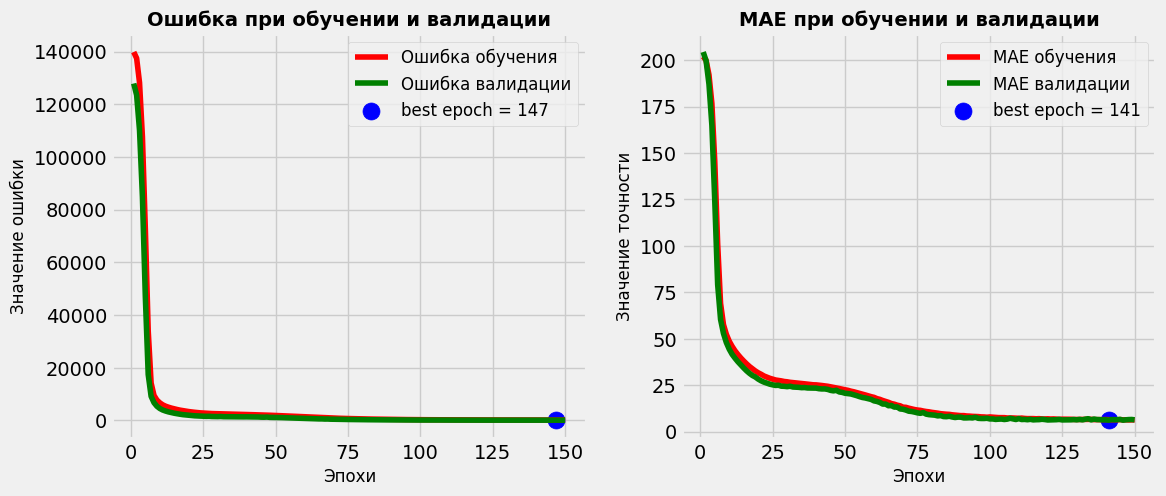

In [ ]:
plot_training_curves(history2)

Видно, что эффекта переобучения на графиках обучения нет

In [ ]:
y_pred = model2.predict(X_test) # обучения модели на тестовом наборе

68/68 [==============================] - 0s 1ms/step


In [ ]:
model2_preformance = generate_preformance_scores(y_test, y_pred) # метрики обучения

mse:	129.9357
mae:	6.5067
r2:	0.9986


Коэффициент детерминации улучшился до 99,86%. Метрики обучения также понизились:
1. mae: 11.29 -> 6.51
2. mse: 725.80 -> 129.93

Время обучения: 143 с

# Другие признаки

Попробуем выбрать признаки корреляция которых по модулю с целевой переменной больше чем 0.8, чтобы проверить как это повляет на обучение

In [ ]:
corr = df.corr()
th=0.8

corr_th = corr["TOTALDOLCOL"][abs(corr["TOTALDOLCOL"]) > th]
corr_th

TOTALDOLCOL    1.000000
KWHCOL         0.968428
BTUELCOL       0.968428
TOTALBTUCOL    0.968428
Name: TOTALDOLCOL, dtype: float64

In [ ]:
df = df.drop(corr["TOTALDOLCOL"][abs(corr["TOTALDOLCOL"]) <= th].keys(), axis=1)
df.head()

,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL
0,17,181.998,620.979,621
1,49,184.459,629.389,629
2,101,1063.022,3627.013,3627
3,0,0.000,0.000,0
4,45,274.530,936.677,937


# Деление на выборки

In [ ]:
# делим выборку на тренировочную и тестовую
X = df.drop(['TOTALDOLCOL'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['TOTALDOLCOL'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.1, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [ ]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (7830, 3)
Размер тестовой выборки: (2175, 3)
Размер валидационной выборки: (870, 3)


In [ ]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Создание модели

## Модель 2

In [ ]:
model2 = keras.Sequential([
    layers.Dense(8, input_dim=X_train.shape[1], activation="relu"), # 1-й слой с 12 нейронами и ФА relu
    layers.Dense(4, activation="relu"), # 2-й слой с 8 нейронами и ФА relu
    layers.Dense(1) # выходной слой с 1 нейроном и линейной ФА, так как задача регрессии
])

In [ ]:
# компиляция модели
model2.compile(optimizer="adam", # оптимизатор adam
              loss="mse", # функция ошибки mse
              metrics=["mae"]) # метрика mae
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8)                 32        
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [ ]:
history2 = model2.fit(X_train, # признаки
                      y_train, # целевой признак
                      epochs=150, # количество эпох обучения
                      batch_size=32, # размер batch
                      validation_data=(X_val, y_val), # данные для валидации
                      callbacks=callbacks_list # ранняя остановка
                      )

Epoch 1/150
245/245 [==============================] - 2s 4ms/step - loss: 138823.9219 - mae: 201.0322 - val_loss: 124866.8438 - val_mae: 201.2135
Epoch 2/150
245/245 [==============================] - 1s 3ms/step - loss: 132573.9844 - mae: 195.3114 - val_loss: 116589.0781 - val_mae: 192.5169
Epoch 3/150
245/245 [==============================] - 1s 3ms/step - loss: 114206.7578 - mae: 180.9602 - val_loss: 89087.7578 - val_mae: 168.6191
Epoch 4/150
245/245 [==============================] - 1s 3ms/step - loss: 80735.6641 - mae: 152.2427 - val_loss: 56754.8633 - val_mae: 135.4984
Epoch 5/150
245/245 [==============================] - 1s 3ms/step - loss: 47680.7812 - mae: 116.5409 - val_loss: 28502.5215 - val_mae: 95.1073
Epoch 6/150
245/245 [==============================] - 1s 3ms/step - loss: 20051.8750 - mae: 74.7873 - val_loss: 8900.4883 - val_mae: 57.2070
Epoch 7/150
245/245 [==============================] - 1s 3ms/step - loss: 8696.0713 - mae: 52.5964 - val_loss: 4743.0869 - val_m

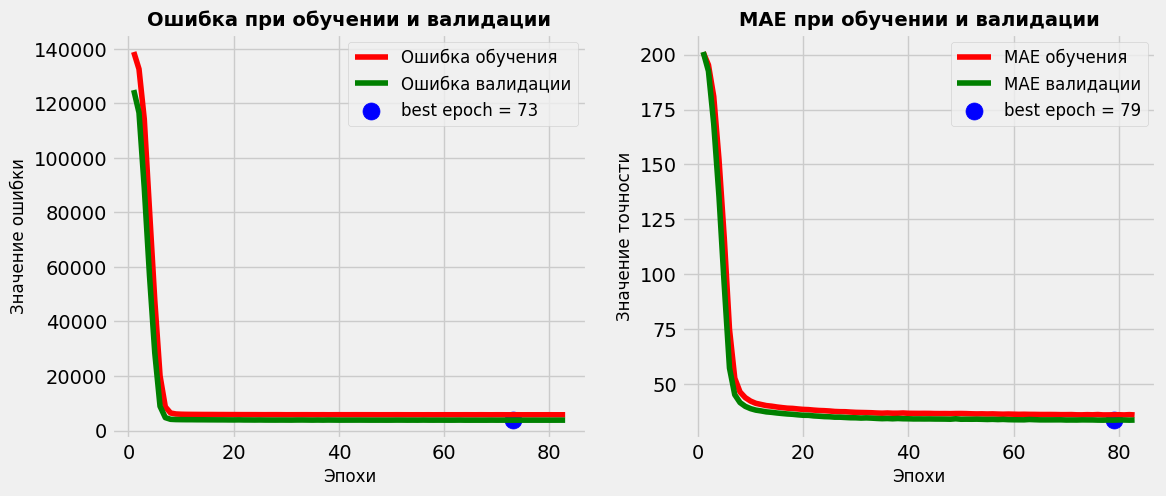

In [ ]:
plot_training_curves(history2)

Видно, что эффекта переобучения на графиках обучения нет

In [ ]:
y_pred = model2.predict(X_test) # обучения модели на тестовом наборе

68/68 [==============================] - 0s 1ms/step


In [ ]:
model3_preformance = generate_preformance_scores(y_test, y_pred) # метрики обучения

mse:	7733.5284
mae:	38.5275
r2:	0.9148


Коэффициент детерминации уменьшился до 91,48%. Метрики заметно увеличились по сравнению с лучшей моделью первого набора данных:
1. mae: 6.51 -> 38.53
2. mse: 129.94 -> 7733.52

Это значит, что модель с меньшмм количеством признаков имеет обобщающую способность меньше, чем модель с большим количеством признаков

In [ ]:
# сведем результаты работы всех моделей в таблицу
performance_df = pd.DataFrame({
    'model_1': model1_preformance,
    'model_2': model2_preformance,
    'model_3': model3_preformance
}).T

performance_df

,mse_score,mae_score,r2_score
model_1,725.804438,11.289136,0.992007
model_2,129.935709,6.506711,0.998569
model_3,7733.528357,38.527455,0.914839


([<matplotlib.axis.XTick at 0x7d600c19f7f0>,
 [Text(0, 0, 'Модель 1'), Text(1, 0, 'Модель 2')])

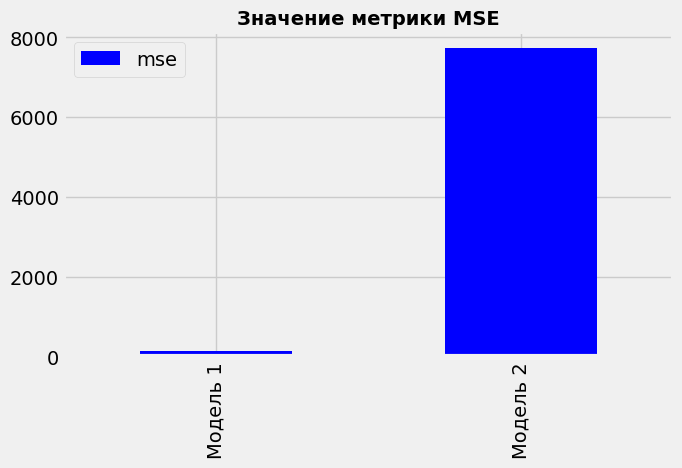

In [ ]:
performance_df["mse_score"].iloc[1:3].plot(kind="bar", figsize=(7, 4), color="blue", label="mse")
plt.title('Значение метрики MSE', fontsize=14, fontweight="bold");
plt.legend()
x_labels = ['Модель 1', 'Модель 2']
plt.xticks(ticks=[0, 1], labels=x_labels)

([<matplotlib.axis.XTick at 0x7d5ffc379660>,
 [Text(0, 0, 'Модель 1'), Text(1, 0, 'Модель 2')])

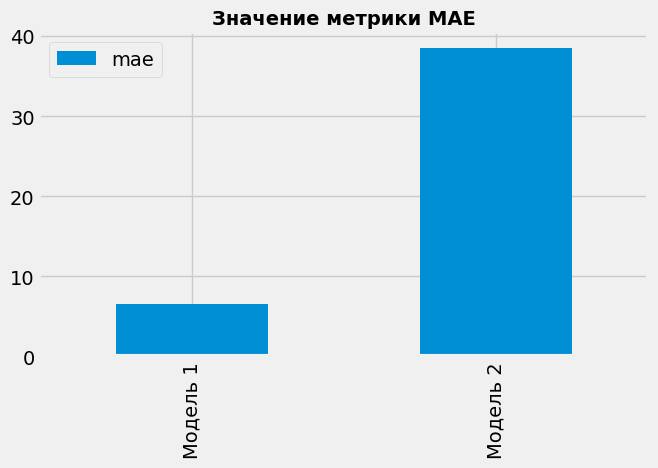

In [ ]:
performance_df["mae_score"].iloc[1:3].plot(kind="bar", figsize=(7, 4), label="mae")
plt.title('Значение метрики MAE', fontsize=14, fontweight="bold");
plt.legend()
x_labels = ['Модель 1', 'Модель 2']
plt.xticks(ticks=[0, 1], labels=x_labels)

([<matplotlib.axis.XTick at 0x7d5ffbfc8190>,
 [Text(0, 0, 'Модель 1'), Text(1, 0, 'Модель 2')])

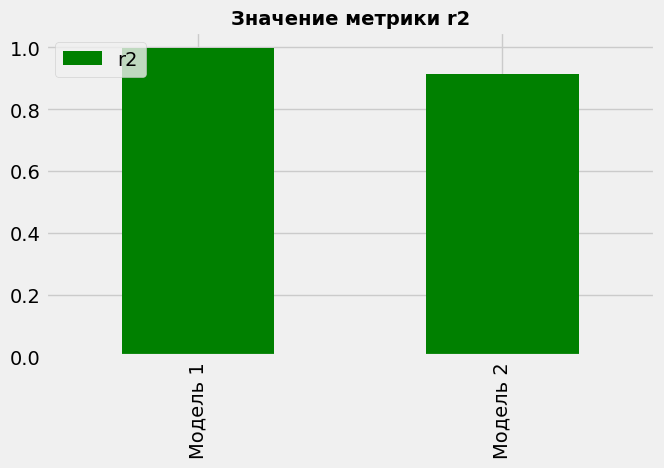

In [ ]:
performance_df["r2_score"].iloc[1:3].plot(kind="bar", figsize=(7, 4), color='green', label="r2")
plt.title('Значение метрики r2', fontsize=14, fontweight="bold");
plt.legend(loc=2)
x_labels = ['Модель 1', 'Модель 2']
plt.xticks(ticks=[0, 1], labels=x_labels)